# Imports and Functions

In [2]:
#Pandas import
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import numpy as np

MLS Teams array for later use

In [51]:
mls_teams = [
    "Atlanta United FC",
    "Austin FC",
    "CF Montréal",
    "Charlotte FC",
    "Chicago Fire FC",
    "Colorado Rapids",
    "Columbus Crew",
    "D.C. United",
    "FC Cincinnati",
    "FC Dallas",
    "Houston Dynamo FC",
    "Inter Miami CF",
    "LA Galaxy",
    "Los Angeles FC",
    "Minnesota United FC",
    "Nashville SC",
    "New England Revolution",
    "New York City FC",
    "New York Red Bulls",
    "Orlando City SC",
    "Philadelphia Union",
    "Portland Timbers",
    "Real Salt Lake",
    "San Jose Earthquakes",
    "Seattle Sounders FC",
    "Sporting Kansas City",
    "St. Louis CITY SC",
    "Toronto FC",
    "Vancouver Whitecaps FC"
]


Function to fix the columns names

In [3]:
def fix_column_names(df):
    for index, column in enumerate(df.columns):
        if '/' in column:
            names = column.split('/')
            first = names[0].strip()
            second = names[0].strip() + " " + names[1].strip()
            
            df.rename(columns={column: first}, inplace=True)
            df.rename(columns={df.columns[index + 1]: second}, inplace=True)
    
    return df

Function to normalize the data in 90 minutes.

In [4]:
def norm_90(df, cols):
    # Sum of given columns
    df_90 = df[cols].sum(numeric_only=True)

    # Create a column for 90m played
    df_90["90s"] = int(df_90["Minutes played"]) / 90

    df_90 = pd.DataFrame(df_90).T

    columns_to_divide = cols[2:]

    # Divide these columns by the values in the '90s' column
    df_90[columns_to_divide] = df_90[columns_to_divide].div(df_90['90s'], axis=0)

    # Drop the 90s column
    df_90.drop("90s", axis=1, inplace=True)

    # Rename the columns to per 90'
    for i in range(1, len(df_90.columns)):
        df_90.columns.values[i] = df_90.columns[i] + '/90'

    df_90["Team"] = df["Team"].iloc[0]
    
    return df_90

Concat all data and per 90 metrics

In [5]:
def team_data(df_list, cols):
    temp_list = []

    for df in df_list:
        df = norm_90(df, cols)
        temp_list.append(df)
    
    teams_df = pd.concat(temp_list)
    teams_df = teams_df.set_index("Team").rename_axis(None)

    return teams_df
     

Function to visualize a metric between all the different teams and divisions

In [6]:
def visualize_metric_between_teams(df, metric, player):
    # Generate a list of colors based on the index count using a colormap
    cmap = plt.colormaps['tab10']
    colors = cmap(np.linspace(0, 1, len(df)))

    # Create bar chart
    plt.figure(figsize=(8, 6))
    bars = plt.bar(df.index, df[metric], color=colors)
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Add title and labels
    plt.title(f"{metric} for {player}", fontsize=14, fontweight='bold')
    plt.xlabel('Club')
    plt.ylabel('Passes Accurate/90')

    # Show plot
    plt.show()

Function that returns a df with a single player data separated by teams

In [ ]:
def df_all_teams(df, teams, cols):
    df_holder = []

    for team in teams:
        if ('II' in team or 'U2' in team):
            temp = df[df['Match'].str.contains(team, na=False)]
        elif team in mls_teams:
            temp = df[df['Match'].str.contains(team, na=False) & ~df['Match'].str.contains('II', na=False)]
        else:
            temp = df[df['Match'].str.contains(team, na=False) & ~df['Match'].str.contains('U2', na=False)]

        temp["Team"] = team
        df_holder.append(temp)
            
    teams_df = team_data(df_holder, cols)
    return teams_df

# Stats for Benjamin Cremaschi

Import the data from an excel from Wyscout and fix the column names

In [7]:
cremaschi_df = pd.read_excel("USA Data/Player stats B. Cremaschi.xlsx", )
cremaschi_df = fix_column_names(cremaschi_df)

Separate dataframe into single dataframes for national teams and clubs

In [8]:
cremaschi_academy_df = cremaschi_df[cremaschi_df["Match"].str.contains("Inter Miami II", na=False)]
cremaschi_academy_df["Team"] = "Inter Miami II"
#cremaschi_academy_df.reset_index(inplace=True, drop=True)

cremaschi_firstteam_df = cremaschi_df[~cremaschi_df['Match'].str.contains('Inter Miami II', na=False) & ~cremaschi_df['Match'].str.contains('United States', na=False)]
cremaschi_firstteam_df["Team"] = "Inter Miami"
#cremaschi_firstteam_df.reset_index(inplace=True, drop=True)

cremaschi_nationalteam_df = cremaschi_df[cremaschi_df["Match"].str.contains("United States", na=False)]
cremaschi_nationalteam_df["Team"] = "United States U20"
#cremaschi_nationalteam_df.reset_index(inplace=True, drop=True)

Get a single df with all clubs and national teams together, metrics per 90'

In [9]:
cols = ["Team", 'Minutes played',
        'Total actions', 'Total actions successful', 'Goals', 'Assists',
        'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
        'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
        'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
        'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
        'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
        'Defensive duels', 'Defensive duels won', 'Loose ball duels',
        'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
        'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
        'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
        'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
        'Through passes accurate', 'xA', 'Second assists',
        'Passes to final third', 'Passes to final third accurate',
        'Passes to penalty area', 'Passes to penalty area accurate',
        'Received passes', 'Forward passes', 'Forward passes accurate',
        'Back passes', 'Back passes accurate']

all_df = [cremaschi_academy_df, cremaschi_firstteam_df, cremaschi_nationalteam_df]
cremaschi_teams_df = team_data(all_df, cols)
cremaschi_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Inter Miami II,1181.0,68.204911,40.160881,0.381033,0.152413,1.066892,0.457240,0.087638,32.692633,26.977138,1.676545,0.990686,0.685859,0.304826,3.048264,1.676545,23.471634,11.354784,1.905165,0.990686,2.514818,9.602032,4.115157,6.553768,2.133785,9.068586,0.0,10.592718,6.096528,2.819644,1.066892,0.22862,0.152413,0.762066,1.600339,0.304826,0.0,0.914479,8.154107,3.200677,1.371719,0.00000,1.524132,1.295512,0.609653,0.152413,0.117358,0.152413,4.115157,2.895851,1.295512,0.533446,23.624047,10.821338,7.773074,5.563082,4.877223
Inter Miami,3366.0,72.219251,46.149733,0.133690,0.133690,1.096257,0.347594,0.139305,40.320856,35.374332,1.283422,0.668449,0.748663,0.240642,2.219251,0.935829,21.764706,9.973262,2.272727,0.962567,2.700535,9.064171,3.716578,5.695187,2.513369,9.064171,0.0,8.048128,5.187166,2.566845,1.096257,0.26738,0.160428,0.695187,1.069519,0.187166,0.0,0.695187,8.877005,2.727273,1.978610,0.13369,1.203209,1.016043,0.695187,0.374332,0.103209,0.026738,3.903743,3.074866,1.497326,0.935829,31.577540,9.331551,7.192513,9.358289,8.796791
United States U20,233.0,86.909871,56.008584,0.386266,0.000000,1.931330,0.772532,0.312876,48.283262,41.330472,0.386266,0.000000,2.703863,1.158798,6.180258,3.090129,26.652361,12.360515,1.931330,1.158798,6.566524,11.974249,4.635193,11.587983,8.111588,0.000000,0.0,8.497854,4.248927,3.862661,2.703863,0.00000,0.000000,0.000000,0.386266,0.000000,0.0,1.931330,12.360515,4.248927,4.248927,0.00000,1.158798,1.545064,1.158798,0.386266,0.262661,0.386266,6.566524,5.021459,3.476395,1.931330,35.922747,15.064378,11.587983,11.201717,11.201717


# Stats for Ricardo Pepi

Import the data from an excel from Wyscout and fix the column names

In [10]:
pepi_df = pd.read_excel('USA Data/Player stats R. Pepi.xlsx')
pepi_df = fix_column_names(pepi_df)

Separate dataframe into single dataframes for national teams and clubs

In [11]:
pepi_u17_df = pepi_df[pepi_df["Match"].str.contains("United States U17", na=False)]
pepi_u17_df["Team"] = "United States U17"

pepi_PSV_df = pepi_df[pepi_df["Match"].str.contains("PSV", na=False)]
pepi_PSV_df["Team"] = "PSV"

pepi_USA_df = pepi_df[pepi_df['Match'].str.contains('United States', na=False) & ~pepi_df['Match'].str.contains('U17', na=False)  & ~pepi_df['Match'].str.contains('U18', na=False)]
pepi_USA_df["Team"] = "United States"

pepi_groningen_df = pepi_df[pepi_df["Match"].str.contains("Groningen", na=False)]
pepi_groningen_df["Team"] = "Groningen"

pepi_northtexas_df = pepi_df[pepi_df["Match"].str.contains("North Texas", na=False)]
pepi_northtexas_df["Team"] = "North Texas"

pepi_dallas_df = pepi_df[pepi_df["Match"].str.contains("Dallas", na=False)]
pepi_dallas_df["Team"] = "Dallas"

Get a single df with all clubs and national teams together, metrics per 90'

In [12]:
cols = ["Team", 'Minutes played',
        'Total actions', 'Total actions successful', 'Goals', 'Assists',
        'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
        'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
        'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
        'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
        'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
        'Defensive duels', 'Defensive duels won', 'Loose ball duels',
        'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
        'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
        'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
        'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
        'Through passes accurate', 'xA', 'Second assists',
        'Passes to final third', 'Passes to final third accurate',
        'Passes to penalty area', 'Passes to penalty area accurate',
        'Received passes', 'Forward passes', 'Forward passes accurate',
        'Back passes', 'Back passes accurate']

all_df = [pepi_u17_df, pepi_dallas_df, pepi_groningen_df, pepi_USA_df, pepi_PSV_df, pepi_northtexas_df]
pepi_teams_df = team_data(all_df, cols)
pepi_teams_df


,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
United States U17,790.0,57.759494,23.582278,0.569620,0.113924,2.164557,1.367089,0.480759,18.911392,14.126582,0.227848,0.113924,0.569620,0.113924,2.050633,0.911392,22.101266,7.746835,3.645570,0.797468,1.936709,11.164557,1.594937,3.531646,2.278481,0.000000,0.0,6.379747,3.075949,3.531646,1.025316,0.000000,0.000000,0.227848,1.708861,0.000000,0.0,0.797468,8.544304,2.848101,4.329114,0.569620,0.455696,0.569620,0.569620,0.227848,0.060380,0.000000,1.481013,1.025316,0.911392,0.683544,11.848101,3.189873,2.164557,5.696203,4.784810
Dallas,3110.0,52.379421,23.064309,0.463023,0.086817,2.372990,1.186495,0.384309,19.475884,15.453376,0.463023,0.173633,0.347267,0.086817,1.765273,0.723473,17.276527,5.932476,3.183280,0.868167,1.620579,8.392283,2.749196,2.864952,1.794212,2.430868,0.0,4.745981,2.430868,3.096463,0.897106,0.231511,0.144695,0.491961,0.897106,0.028939,0.0,0.897106,6.250804,1.736334,3.675241,0.434084,0.520900,0.723473,0.665595,0.289389,0.079003,0.086817,1.186495,0.752412,0.810289,0.434084,15.163987,3.038585,1.996785,6.077170,5.440514
Groningen,2724.0,53.359031,21.872247,0.495595,0.066079,1.916300,0.892070,0.313877,16.552863,13.281938,0.231278,0.198238,0.231278,0.099119,1.651982,0.726872,21.211454,7.202643,6.409692,1.982379,2.610132,10.308370,2.940529,2.841410,1.751101,1.949339,0.0,3.898678,2.378855,4.262115,1.288546,0.033040,0.033040,1.057269,0.627753,0.066079,0.0,0.594714,6.640969,1.552863,3.634361,0.495595,0.528634,0.198238,0.132159,0.033040,0.062775,0.066079,0.825991,0.495595,0.660793,0.429515,11.464758,1.982379,1.123348,5.748899,5.088106
United States,1346.0,48.945022,21.597325,0.601783,0.066865,2.741456,1.471025,0.578380,16.916790,14.576523,0.066865,0.066865,0.200594,0.133730,1.337296,0.401189,16.783061,5.215453,2.875186,0.601783,1.939079,8.023774,1.738484,3.142645,2.540862,0.000000,0.0,3.677563,2.139673,4.346211,1.671620,0.200594,0.133730,0.267459,0.735513,0.000000,0.0,0.468053,5.884101,0.802377,4.413076,0.267459,0.668648,0.200594,0.200594,0.066865,0.039450,0.000000,1.069837,0.668648,0.401189,0.200594,12.303120,2.607727,1.805349,5.817236,5.549777
PSV,1159.0,53.192407,24.305436,0.776531,0.232959,2.640207,1.397757,0.587058,21.199310,16.695427,0.698878,0.388266,0.232959,0.077653,1.320104,0.621225,19.102675,5.823986,3.805004,1.009491,1.708369,9.163072,3.028473,2.407248,1.553063,19.646247,0.0,3.882657,2.329594,3.805004,1.087144,0.155306,0.077653,0.776531,0.776531,0.232959,0.0,1.009491,7.610009,1.397757,4.969802,0.543572,0.776531,0.310613,0.232959,0.077653,0.072994,0.000000,1.320104,0.854185,1.009491,0.621225,15.763589,3.572045,2.407248,6.600518,5.746333
North Texas,1279.0,52.212666,24.910086,0.774042,0.000000,4.010946,1.618452,0.761376,21.884285,16.958561,0.774042,0.562940,0.774042,0.211102,2.673964,1.266615,15.903049,5.981235,2.814699,1.196247,0.703675,8.936669,1.477717,2.251759,1.688819,0.000000,0.0,3.588741,2.040657,1.970289,0.703675,0.140735,0.070367,0.140735,0.281470,0.000000,0.0,0.422205,7.529320,2.040657,3.799844,0.84

# Stats for Brendan Aaronson

Import the data from an excel from Wyscout and fix the column names

In [13]:
aaronson_df = pd.read_excel("USA Data/Player stats B. Aaronson.xlsx")
aaronson_df = fix_column_names(aaronson_df)

Separate dataframe into single dataframes for national teams and clubs

In [14]:
aaronson_bethlehemsteel_df = aaronson_df[aaronson_df["Match"].str.contains("Bethlehem Steel", na=False)]
aaronson_bethlehemsteel_df["Team"] = "Bethlehem Steel"

aaronson_philadelphia_df = aaronson_df[aaronson_df["Match"].str.contains("Philadelphia Union", na=False)]
aaronson_philadelphia_df["Team"] = "Philadelphia Union"

aaronson_salzburg_df = aaronson_df[aaronson_df["Match"].str.contains("Salzburg", na=False)]
aaronson_salzburg_df["Team"] = "Salzburg"

aaronson_leeds_df = aaronson_df[aaronson_df["Match"].str.contains("Leeds", na=False)]
aaronson_leeds_df["Team"] = "Leeds"

aaronson_unionberlin_df = aaronson_df[aaronson_df["Match"].str.contains("Union Berlin", na=False)]
aaronson_unionberlin_df["Team"] = "Union Berlin"

aaronson_USA_df = aaronson_df[aaronson_df['Match'].str.contains('United States', na=False) & ~aaronson_df['Match'].str.contains('U23', na=False)]
aaronson_USA_df["Team"] = "United States"

Get a single df with all clubs and national teams together, metrics per 90'

In [15]:
cols = ["Team", 'Minutes played',
        'Total actions', 'Total actions successful', 'Goals', 'Assists',
        'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
        'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
        'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
        'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
        'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
        'Defensive duels', 'Defensive duels won', 'Loose ball duels',
        'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
        'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
        'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
        'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
        'Through passes accurate', 'xA', 'Second assists',
        'Passes to final third', 'Passes to final third accurate',
        'Passes to penalty area', 'Passes to penalty area accurate',
        'Received passes', 'Forward passes', 'Forward passes accurate',
        'Back passes', 'Back passes accurate']

all_df = [aaronson_bethlehemsteel_df, aaronson_leeds_df, aaronson_philadelphia_df, aaronson_salzburg_df, aaronson_USA_df, aaronson_unionberlin_df]
aaronson_teams_df = team_data(all_df, cols)
aaronson_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Bethlehem Steel,1296.0,65.277778,30.625000,0.069444,0.277778,1.388889,0.486111,0.165278,28.402778,21.250000,1.388889,0.555556,0.902778,0.347222,3.472222,1.458333,21.666667,8.055556,3.958333,0.972222,2.361111,12.847222,3.402778,4.583333,2.569444,0.416667,0.000000,5.416667,2.847222,3.888889,1.527778,0.347222,0.208333,0.902778,1.041667,0.069444,0.000000,0.972222,8.402778,2.708333,2.569444,0.069444,0.972222,1.041667,1.388889,0.486111,0.105556,0.138889,3.958333,2.222222,2.083333,1.041667,20.555556,7.569444,4.305556,6.875000,6.180556
Leeds,3117.0,67.478345,32.743022,0.028874,0.173244,1.241578,0.317613,0.155053,26.217517,20.875842,0.692974,0.259865,1.126083,0.173244,3.666987,2.050048,23.878730,10.076997,1.963426,0.230991,2.107796,11.116458,2.656400,4.533205,2.656400,3.695861,0.000000,6.352262,4.128970,3.984601,1.126083,0.115496,0.086622,0.259865,0.577478,0.057748,0.000000,1.385948,11.578441,4.590953,2.454283,0.230991,1.559192,1.905679,0.635226,0.230991,0.151299,0.028874,2.887392,1.992300,1.616939,0.721848,18.941290,6.900866,4.706449,6.467757,5.976901
Philadelphia Union,4312.0,63.116883,31.725417,0.146104,0.125232,1.523655,0.542672,0.185969,25.317718,20.809369,0.521800,0.187848,0.876623,0.229592,3.840445,1.440167,22.771336,9.162801,1.628015,0.459184,2.671614,8.703618,2.421150,4.800557,2.692486,1.941095,0.000000,7.785250,4.341373,3.715213,1.335807,0.125232,0.041744,0.292208,0.730519,0.062616,0.000000,0.980983,9.642857,3.026438,2.984694,0.125232,1.419295,1.461039,0.960111,0.354824,0.101647,0.125232,2.045455,1.377551,1.607143,0.814007,18.847403,6.553803,4.696197,5.865028,5.447588
Salzburg,5436.0,65.678808,33.029801,0.264901,0.264901,1.804636,0.695364,0.229139,28.642384,21.937086,1.341060,0.513245,1.672185,0.480132,3.973510,1.903974,22.417219,9.139073,2.798013,0.596026,2.384106,11.986755,3.162252,4.718543,2.731788,1.456954,0.000000,5.231788,3.228477,4.039735,1.274834,0.082781,0.033113,0.248344,0.794702,0.016556,0.000000,1.440397,10.347682,4.039735,3.658940,0.413907,1.324503,1.821192,1.274834,0.347682,0.167881,0.066225,2.864238,1.721854,2.996689,1.440397,20.264901,7.384106,4.420530,6.639073,6.192053
United States,2069.0,63.291445,33.711938,0.347994,0.130498,1.826970,0.869986,0.292315,24.968584,21.445143,0.695988,0.391493,1.174480,0.391493,3.523441,1.739971,22.663122,10.091832,1.174480,0.391493,2.218463,8.960851,2.174964,4.523925,2.870952,0.000000,0.000000,8.612856,4.828420,3.088449,1.043983,0.130498,0.086999,0.130498,1.217980,0.000000,0.000000,0.913485,9.787337,3.827936,3.827936,0.260996,1.391977,2.131464,0.565491,0.173997,0.160512,0.000000,2.087965,1.739971,1.565974,0.782987,20.488159,4.567424,3.566941,7.873369,7.525375
Union Berlin,1969.0,68.334180,36.338243,0.182834,0.091417,1.234129,0.502793,0.140782,27.927882,23.174200,0.502793,0.319959,1.142712,0.365668,4.845099,2.468258,26.145251,11.244286,2.148299,0.548502,2.559675,10.330117,2.696800,6.079228,3.062468,2.513966,0.959878,7.221940,4.479431,3.930929,1.234129,0.000000,0.0000

# Stats for Caleb Wiley

Import the data from an excel from Wyscout and fix the column names

In [16]:
wiley_df = pd.read_excel("USA Data/Player stats C. Wiley.xlsx")
wiley_df = fix_column_names(wiley_df)

Separate dataframe into single dataframes for national teams and clubs

In [17]:
wiley_atlantaII_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United II', na=False)]
wiley_atlantaII_df["Team"] = "Atlanta United II"

wiley_atlanta_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United', na=False) & ~wiley_df['Match'].str.contains('II', na=False)]
wiley_atlanta_df["Team"] = "Atlanta United"

wiley_USA23_df = wiley_df[wiley_df['Match'].str.contains('United States U23', na=False)]
wiley_USA23_df["Team"] = "United States U23"

wiley_USA20_df = wiley_df[wiley_df['Match'].str.contains('United States U20', na=False)]
wiley_USA20_df["Team"] = "United States U20"

wiley_USA16_df = wiley_df[wiley_df['Match'].str.contains('United States U16', na=False)]
wiley_USA16_df["Team"] = "United States U16"

Get a single df with all clubs and national teams together, metrics per 90'

In [18]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [wiley_USA16_df, wiley_atlanta_df, wiley_atlantaII_df, wiley_USA20_df, wiley_USA23_df]
wiley_teams_df = team_data(all_df, cols)
wiley_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
United States U16,94.0,80.425532,58.404255,0.000000,0.000000,0.000000,0.000000,0.000000,58.404255,50.744681,2.872340,1.914894,1.914894,1.914894,1.914894,0.957447,14.361702,3.829787,4.787234,4.787234,2.872340,9.574468,4.787234,0.000000,0.0,3.829787,1.914894,2.872340,0.000000,0.000000,0.000000,0.957447,0.957447,0.000000,0.0,0.000000,6.702128,1.914894,0.957447,0.000000,0.957447,0.000000,0.000000,0.000000,0.000000,0.000000,4.787234,2.872340,0.957447,0.957447,42.127660,22.021277,18.191489,10.531915,10.531915
Atlanta United,6633.0,61.289009,39.036635,0.081411,0.081411,0.298507,0.149254,0.051696,37.951153,31.112619,2.537313,1.180461,2.225237,0.719132,2.021710,1.004071,15.006784,6.580733,4.518318,9.321574,3.934871,6.689281,2.008141,2.293080,0.0,6.417910,3.392130,1.967436,0.664858,0.054274,0.000000,1.451832,1.004071,0.054274,0.0,0.705563,4.572592,1.682497,1.981004,0.067843,2.021710,0.502035,0.257802,0.135685,0.087246,0.040706,3.188602,2.279512,1.858887,1.004071,28.710991,11.994573,8.873813,8.100407,7.557666
Atlanta United II,3014.0,65.424685,41.446583,0.000000,0.059721,0.298607,0.059721,0.013736,39.147313,30.816191,3.374253,1.731918,2.896483,0.985401,2.568016,1.373590,17.617784,8.898474,5.643663,10.719973,4.359655,8.271400,2.090246,6.987392,0.0,8.122097,4.568679,2.149967,0.985401,0.507631,0.358328,1.731918,0.686795,0.119443,0.0,0.925680,5.046450,2.060385,1.224287,0.238885,2.269409,0.567352,0.388188,0.119443,0.102422,0.000000,3.971466,2.657598,2.777040,1.343729,28.039151,14.392833,10.182482,8.480425,8.002654
United States U20,617.0,66.807131,42.009724,0.145867,0.000000,0.437601,0.291734,0.153160,41.280389,32.236629,2.771475,1.312804,3.938412,1.604538,3.792545,1.896272,16.774716,7.876823,4.521880,9.918963,3.354943,7.001621,3.354943,0.000000,0.0,5.397083,3.646677,2.771475,0.583468,0.291734,0.145867,2.042139,0.875203,0.000000,0.0,1.166937,7.001621,2.479741,2.771475,0.291734,2.042139,0.875203,0.145867,0.000000,0.106483,0.000000,3.646677,2.917342,2.479741,1.166937,31.507293,10.064830,7.001621,12.690438,11.377634
United States U23,155.0,67.354839,45.870968,0.000000,0.000000,0.000000,0.000000,0.000000,42.967742,33.677419,1.741935,0.000000,0.000000,0.000000,1.161290,0.000000,17.419355,9.290323,5.806452,13.935484,8.709677,9.290323,2.322581,0.000000,0.0,6.967742,5.806452,1.741935,1.161290,0.000000,0.000000,1.741935,0.000000,0.000000,0.0,0.580645,6.967742,1.161290,0.580645,0.000000,0.580645,0.580645,0.000000,0.000000,0.011613,0.000000,4.064516,3.483871,0.000000,0.000000,28.451613,19.161290,12.193548,5.806452,5.225806


# Stats for Noah Cobb

Import the data from an excel from Wyscout and fix the column names

In [19]:
cobb_df = pd.read_excel("USA Data/Player stats N. Cobb.xlsx")
cobb_df = fix_column_names(cobb_df)

Separate dataframe into single dataframes for national teams and clubs

In [20]:
cobb_atlantaII_df = cobb_df[cobb_df['Match'].str.contains('Atlanta United II', na=False)]
cobb_atlantaII_df["Team"] = "Atlanta United II"

cobb_atlanta_df = cobb_df[cobb_df['Match'].str.contains('Atlanta United', na=False) & ~cobb_df['Match'].str.contains('II', na=False)]
cobb_atlanta_df["Team"] = "Atlanta United"

Get a single df with all clubs and national teams together, metrics per 90'

In [21]:
cols = ["Team",'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
       'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
       'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
       'Defensive duels', 'Defensive duels won', 'Loose ball duels',
       'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
       'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
       'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
       'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [cobb_atlanta_df, cobb_atlantaII_df]
cobb_teams_df = team_data(all_df, cols)
cobb_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Atlanta United,1661.0,64.316677,48.332330,0.000000,0.000000,0.054184,0.054184,0.019506,46.598435,40.909091,6.556291,3.088501,0.054184,0.054184,0.216737,0.054184,11.920530,6.502107,3.738712,1.788079,4.822396,7.531607,4.388922,9.265503,1.679711,4.551475,0.000000,5.743528,3.630343,1.788079,0.975316,0.433474,0.270921,3.196869,0.541842,0.108368,0.000000,0.108368,0.650211,0.108368,0.108368,0.0,0.379290,0.270921,0.541842,0.054184,0.007044,0.000000,3.792896,2.167369,0.487658,0.108368,33.865141,17.772426,13.329320,3.630343,3.576159
Atlanta United II,4620.0,71.240260,53.064935,0.058442,0.019481,0.116883,0.077922,0.019091,51.214286,43.753247,8.649351,4.402597,0.019481,0.019481,0.175325,0.097403,11.688312,6.915584,2.357143,1.402597,5.824675,8.181818,4.889610,9.564935,1.032468,6.545455,2.318182,6.759740,4.383117,1.831169,0.857143,0.584416,0.311688,2.961039,0.681818,0.116883,0.038961,0.038961,0.740260,0.272727,0.155844,0.0,0.155844,0.311688,0.701299,0.194805,0.003312,0.019481,4.889610,2.707792,0.428571,0.097403,36.720779,20.571429,14.980519,2.337662,2.220779


# Stats for Q. Sullivan

Import the data from an excel from Wyscout and fix the column names

In [22]:
sullivan_df = pd.read_excel("USA Data/Player stats Q. Sullivan.xlsx")
sullivan_df = fix_column_names(sullivan_df)

In [23]:
sullivan_df

,Match,Competition,Date,Position,Minutes played,Total actions,Total actions successful,Goals,Assists,Shots,Shots on target,xG,Passes,Passes accurate,Long passes,Long passes accurate,Crosses,Crosses accurate,Dribbles,Dribbles successful,Duels,Duels won,Aerial duels,Aerial duels won,Interceptions,Losses,Losses own half,Recoveries,Recoveries opp. half,Yellow card,Red card,Defensive duels,Defensive duels won,Loose ball duels,Loose ball duels won,Sliding tackles,Sliding tackles successful,Clearances,Fouls,Yellow cards,Red cards,Shot assists,Offensive duels,Offensive duels won,Touches in penalty area,Offsides,Progressive runs,Fouls suffered,Through passes,Through passes accurate,xA,Second assists,Passes to final third,Passes to final third accurate,Passes to penalty area,Passes to penalty area accurate,Received passes,Forward passes,Forward passes accurate,Back passes,Back passes accurate
0,CF Montréal - Philadelphia Union 4:2,United States. MLS,2024-06-30,"CF, RW",102,69,44,1,0,3,3,0.20,43,31,2,1,4,2,3,2,14,8,0,0,3,14,2,6,2,0,0,6,4,2,2,0,0,2,0,0,0,1,6,2,2,0,4,0,1,1,0.03,0,5,5,3,3,27,17,12,5,4
1,Philadelphia Union - Charlotte FC 0:2,United States. MLS,2024-06-23,RCMF3,102,72,47,0,0,3,2,0.30,47,39,2,0,4,2,5,2,15,5,2,0,2,13,4,3,2,0,0,5,2,1,0,0,0,0,1,0,0,2,7,3,8,0,2,0,0,0,0.54,0,4,3,3,3,40,6,5,14,11
2,Cincinnati - Philadelphia Union 4:3,United States. MLS,2024-06-20,"CF, RAMF, RCMF3",32,17,10,0,0,0,0,0.00,12,10,0,0,0,0,2,0,3,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,0,1,0,1,0,0,0,0.01,0,2,2,0,0,11,1,1,6,6
3,Philadelphia Union - Inter Miami 1:2,United States. MLS,2024-06-16,"CF, RB",102,56,30,0,0,3,0,0.29,22,17,1,0,0,0,8,6,20,13,1,0,2,10,2,3,2,0,0,5,3,1,1,0,0,2,1,0,0,1,13,9,4,1,6,2,0,0,0.02,0,2,1,0,0,14,8,6,7,6
4,Philadelphia Union - CF Montréal 2:2,United States. MLS,2024-06-02,"RB, RWB, CF",52,36,22,0,0,1,1,0.02,24,17,0,0,6,0,5,3,11,4,0,0,0,9,0,1,1,0,0,1,1,1,0,0,0,0,0,0,0,1,9,3,1,0,0,0,0,0,0.35,0,2,2,7,1,17,4,3,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Pittsburgh Riverhounds - Philadelphia Union II...,United States. USL Championship,2020-08-02,RW,49,22,7,0,0,0,0,0.00,6,5,0,0,0,0,1,0,8,2,1,0,0,6,1,1,0,0,0,1,1,3,1,2,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0.00,0,1,0,1,1,3,1,1,1,1
135,Hartford Athletic - Philadelphia Union II 3:2,United States. USL Championship,2020-07-26,RW,39,21,11,0,0,0,0,0.00,10,7,0,0,0,0,1,0,7,4,1,1,1,5,3,2,1,0,0,3,2,1,1,1,1,0,0,0,0,1,2,0,1,1,0,0,0,0,0.08,0,1,1,0,0,7,5,4,2,2
136,Philadelphia Union II - New York RB II 1:5,United States. USL Championship,2020-07-23,CF,8,5,3,0,0,0,0,0.00,3,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.00,0,1,1,0,0,3,3,3,0,0
137,Philadelphia Union II - Pittsburgh Riverhounds...,United States. USL Championship,2020-07-19,CF,48,23,7,0,0,0,0,0.00,12,6,1,1,0,0,2,0,4,0,1,0,0,6,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0.00,0,2,1,0,0,8,5,1,5,4


Separate dataframe into single dataframes for national teams and clubs

In [24]:
sullivan_philadelphiaII_df = sullivan_df[sullivan_df['Match'].str.contains('Philadelphia Union II', na=False)]
sullivan_philadelphiaII_df["Team"] = "Philadelphia Union II"

sullivan_philadelphia_df = sullivan_df[sullivan_df['Match'].str.contains('Philadelphia Union', na=False) & ~sullivan_df['Match'].str.contains('II', na=False)]
sullivan_philadelphia_df["Team"] = "Philadelphia Union"

Get a single df with all clubs and national teams together, metrics per 90'

In [25]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won', 'Aerial duels',
       'Aerial duels won', 'Interceptions', 'Losses', 'Losses own half',
       'Recoveries', 'Recoveries opp. half', 'Yellow card', 'Red card',
       'Defensive duels', 'Defensive duels won', 'Loose ball duels',
       'Loose ball duels won', 'Sliding tackles', 'Sliding tackles successful',
       'Clearances', 'Fouls', 'Yellow cards', 'Red cards', 'Shot assists',
       'Offensive duels', 'Offensive duels won', 'Touches in penalty area',
       'Offsides', 'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [sullivan_philadelphia_df, sullivan_philadelphiaII_df]
sullivan_teams_df = team_data(all_df, cols)
sullivan_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Aerial duels/90,Aerial duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Philadelphia Union,4412.0,57.239347,29.700816,0.163191,0.142792,1.835902,0.815956,0.171351,26.294198,20.460109,1.366727,0.713962,2.672257,0.775159,3.263826,1.958296,18.236627,7.364007,2.345875,0.632366,2.060290,9.934270,2.203083,3.875793,2.264279,8.81233,0.0,5.120127,2.835449,2.855848,0.938350,0.632366,0.203989,0.489574,1.060743,0.142792,0.0,0.979148,7.914778,2.957842,3.182230,0.244787,2.345875,0.367180,0.285585,0.122393,0.14524,0.081596,2.141886,1.529918,2.733454,1.325929,20.358114,5.874887,4.079782,6.180870,5.711695
Philadelphia Union II,1428.0,66.680672,35.168067,0.189076,0.252101,2.142857,1.071429,0.218697,31.323529,22.626050,3.025210,1.260504,3.340336,1.197479,4.222689,1.890756,20.294118,9.201681,1.827731,0.378151,2.521008,11.659664,2.268908,4.915966,2.962185,0.00000,0.0,8.319328,4.474790,2.394958,1.071429,1.071429,0.693277,0.378151,1.764706,0.000000,0.0,1.071429,7.752101,3.277311,4.222689,0.315126,2.773109,0.441176,1.071429,0.315126,0.22500,0.126050,5.294118,3.214286,4.915966,2.268908,22.121849,10.021008,6.680672,5.231092,4.726891


# Stats for D. Luna

Import the data from an excel from Wyscout and fix the column names

In [26]:
luna_df = pd.read_excel("USA Data/Player stats D. Luna.xlsx")
luna_df = fix_column_names(luna_df)

Separate dataframe into single dataframes for national teams and clubs

In [27]:
luna_saltlake_df = luna_df[luna_df['Match'].str.contains('Real Salt Lake', na=False)]
luna_saltlake_df["Team"] = "Real Salt Lake"

luna_elpasolocomotive_df = luna_df[luna_df['Match'].str.contains('El Paso Locomotive', na=False)]
luna_elpasolocomotive_df["Team"] = "El Paso Locomotive"

luna_u20_df = luna_df[luna_df["Match"].str.contains("United States U20", na=False)]
luna_u20_df["Team"] = "United States U20"

Get a single df with all clubs and national teams together, metrics per 90'

In [28]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [luna_elpasolocomotive_df, luna_saltlake_df, luna_u20_df]
luna_teams_df = team_data(all_df, cols)
luna_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
El Paso Locomotive,3176.0,74.442695,47.947103,0.368388,0.198363,2.125315,1.105164,0.277141,42.081234,35.875315,1.388539,0.878463,1.246851,0.453401,6.886020,3.513854,21.338161,9.748111,1.785264,10.031486,2.437028,3.797229,2.352015,21.338161,2.18199,4.845718,2.805416,2.607053,0.991814,0.510076,0.198363,0.085013,1.105164,0.283375,0.028338,1.558564,13.120277,5.752519,3.258816,0.113350,3.598866,1.586902,0.850126,0.311713,0.183627,0.198363,5.214106,3.967254,2.720403,1.643577,32.984887,10.824937,8.132872,9.124685,8.727960
Real Salt Lake,3947.0,67.357487,43.027616,0.250823,0.114011,1.459336,0.592855,0.163491,38.923233,33.268305,1.983785,1.254117,0.524449,0.205219,3.351913,1.983785,17.648847,8.094756,2.599443,9.622498,2.827464,5.130479,2.736255,7.866734,0.00000,5.016468,3.123892,2.211806,0.775272,0.342032,0.182417,0.387636,0.843679,0.114011,0.000000,1.527743,9.508487,3.944768,2.052192,0.136813,2.189004,1.140106,0.638460,0.228021,0.109906,0.114011,5.039270,3.807955,1.573347,1.048898,30.167216,8.619204,6.430200,9.645300,9.029643
United States U20,1294.0,76.367852,49.729521,0.347759,0.417311,2.225657,0.834621,0.436785,45.486862,39.227202,2.503864,1.599691,0.695518,0.347759,5.772798,3.129830,19.335394,8.554869,1.947450,9.459042,2.156105,4.451314,3.129830,13.284389,0.00000,4.381762,2.573416,2.225657,0.765070,0.208655,0.069552,0.208655,0.695518,0.208655,0.000000,1.808346,12.102009,4.938176,2.990726,0.139104,2.364760,0.973725,1.112828,0.556414,0.195440,0.069552,6.468315,5.355487,3.199382,2.156105,34.775889,12.867079,10.224111,10.502318,9.806801


# Stats for

Import the data from an excel from Wyscout and fix the column names

In [48]:
tessman_df = pd.read_excel("USA Data/Player stats T. Tessmann.xlsx")
tessman_df = fix_column_names(tessman_df)

Separate dataframe into single dataframes for national teams and clubs

In [31]:
tessman_venezia_df = tessman_df[tessman_df['Match'].str.contains('Venezia', na=False)]
tessman_venezia_df["Team"] = "Venezia"

tessman_northtexas_df = tessman_df[tessman_df['Match'].str.contains('North Texas', na=False)]
tessman_northtexas_df["Team"] = "North Texas"

tessman_dallas_df = tessman_df[tessman_df['Match'].str.contains('Dallas', na=False)]
tessman_dallas_df["Team"] = "Dallas"

tessman_u23_df = tessman_df[tessman_df['Match'].str.contains('United States U23', na=False)]
tessman_u23_df["Team"] = "United States U23"

Get a single df with all clubs and national teams together, metrics per 90'

In [63]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

teams = ["Venezia", "North Texas", "Dallas", "United States U23"]
tessman_teams_df = df_all_teams(tessman_df, teams, cols)
tessman_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Venezia,7756.0,71.387313,47.761733,0.116039,0.046416,1.322847,0.406137,0.100026,45.394533,37.654719,6.707065,3.782878,0.986333,0.313306,2.088706,1.137184,16.605209,7.890665,4.363074,9.225116,3.527592,7.670191,3.388345,9.979371,2.065498,5.477050,3.283909,2.831356,1.044353,0.278494,0.127643,1.566529,0.928314,0.162455,0.023208,0.638216,5.964415,2.460031,0.649819,0.023208,1.415678,1.044353,1.160392,0.371325,0.071828,0.092831,8.598504,6.068850,2.251160,0.847086,32.502579,13.100825,8.714544,5.894791,5.651109
North Texas,978.0,74.815951,45.460123,0.092025,0.000000,2.300613,0.736196,0.122393,41.042945,32.944785,6.257669,3.036810,0.552147,0.092025,3.128834,1.656442,22.638037,10.582822,2.392638,10.582822,3.404908,6.533742,3.588957,7.177914,0.000000,7.546012,4.877301,2.944785,1.104294,0.276074,0.184049,1.104294,1.472393,0.184049,0.000000,0.736196,8.834356,3.128834,1.012270,0.184049,1.104294,1.104294,1.380368,0.368098,0.063497,0.000000,7.822086,5.153374,2.944785,1.380368,29.631902,12.975460,8.742331,6.809816,6.073620
Dallas,1840.0,72.097826,48.472826,0.000000,0.048913,1.173913,0.195652,0.028859,45.146739,38.103261,6.945652,3.815217,0.586957,0.244565,2.103261,1.125000,18.635870,8.804348,3.913043,7.728261,3.179348,8.266304,3.277174,1.516304,0.000000,6.847826,3.913043,2.641304,0.782609,0.293478,0.146739,1.222826,0.880435,0.048913,0.000000,0.635870,6.065217,2.494565,0.489130,0.000000,1.418478,0.635870,0.929348,0.146739,0.042554,0.000000,7.434783,4.842391,1.565217,0.586957,32.527174,11.983696,8.119565,6.358696,6.114130
United States U23,382.0,65.261780,46.178010,0.000000,0.000000,0.706806,0.000000,0.007068,43.586387,36.753927,6.596859,4.005236,0.471204,0.235602,2.827225,1.884817,13.664921,7.539267,3.534031,6.361257,2.356021,8.717277,4.240838,28.743455,0.000000,5.183246,3.298429,0.942408,0.706806,0.000000,0.000000,0.471204,1.413613,0.471204,0.000000,0.471204,5.654450,3.062827,1.413613,0.000000,0.706806,0.942408,2.120419,0.942408,0.011780,0.000000,10.130890,7.068063,0.942408,0.235602,30.157068,12.015707,8.246073,6.596859,6.361257


In [55]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [tessman_dallas_df, tessman_northtexas_df, tessman_venezia_df, tessman_u23_df]
tessman_teams_df = team_data(all_df, cols)
tessman_teams_df

,Minutes played,Total actions/90,Total actions successful/90,Goals/90,Assists/90,Shots/90,Shots on target/90,xG/90,Passes/90,Passes accurate/90,Long passes/90,Long passes accurate/90,Crosses/90,Crosses accurate/90,Dribbles/90,Dribbles successful/90,Duels/90,Duels won/90,Interceptions/90,Losses/90,Losses own half/90,Recoveries/90,Recoveries opp. half/90,Yellow card/90,Red card/90,Defensive duels/90,Defensive duels won/90,Loose ball duels/90,Loose ball duels won/90,Sliding tackles/90,Sliding tackles successful/90,Clearances/90,Fouls/90,Yellow cards/90,Red cards/90,Shot assists/90,Offensive duels/90,Offensive duels won/90,Touches in penalty area/90,Offsides/90,Progressive runs/90,Fouls suffered/90,Through passes/90,Through passes accurate/90,xA/90,Second assists/90,Passes to final third/90,Passes to final third accurate/90,Passes to penalty area/90,Passes to penalty area accurate/90,Received passes/90,Forward passes/90,Forward passes accurate/90,Back passes/90,Back passes accurate/90
Dallas,1840.0,72.097826,48.472826,0.000000,0.048913,1.173913,0.195652,0.028859,45.146739,38.103261,6.945652,3.815217,0.586957,0.244565,2.103261,1.125000,18.635870,8.804348,3.913043,7.728261,3.179348,8.266304,3.277174,1.516304,0.000000,6.847826,3.913043,2.641304,0.782609,0.293478,0.146739,1.222826,0.880435,0.048913,0.000000,0.635870,6.065217,2.494565,0.489130,0.000000,1.418478,0.635870,0.929348,0.146739,0.042554,0.000000,7.434783,4.842391,1.565217,0.586957,32.527174,11.983696,8.119565,6.358696,6.114130
North Texas,978.0,74.815951,45.460123,0.092025,0.000000,2.300613,0.736196,0.122393,41.042945,32.944785,6.257669,3.036810,0.552147,0.092025,3.128834,1.656442,22.638037,10.582822,2.392638,10.582822,3.404908,6.533742,3.588957,7.177914,0.000000,7.546012,4.877301,2.944785,1.104294,0.276074,0.184049,1.104294,1.472393,0.184049,0.000000,0.736196,8.834356,3.128834,1.012270,0.184049,1.104294,1.104294,1.380368,0.368098,0.063497,0.000000,7.822086,5.153374,2.944785,1.380368,29.631902,12.975460,8.742331,6.809816,6.073620
Venezia,7756.0,71.387313,47.761733,0.116039,0.046416,1.322847,0.406137,0.100026,45.394533,37.654719,6.707065,3.782878,0.986333,0.313306,2.088706,1.137184,16.605209,7.890665,4.363074,9.225116,3.527592,7.670191,3.388345,9.979371,2.065498,5.477050,3.283909,2.831356,1.044353,0.278494,0.127643,1.566529,0.928314,0.162455,0.023208,0.638216,5.964415,2.460031,0.649819,0.023208,1.415678,1.044353,1.160392,0.371325,0.071828,0.092831,8.598504,6.068850,2.251160,0.847086,32.502579,13.100825,8.714544,5.894791,5.651109
United States U23,382.0,65.261780,46.178010,0.000000,0.000000,0.706806,0.000000,0.007068,43.586387,36.753927,6.596859,4.005236,0.471204,0.235602,2.827225,1.884817,13.664921,7.539267,3.534031,6.361257,2.356021,8.717277,4.240838,28.743455,0.000000,5.183246,3.298429,0.942408,0.706806,0.000000,0.000000,0.471204,1.413613,0.471204,0.000000,0.471204,5.654450,3.062827,1.413613,0.000000,0.706806,0.942408,2.120419,0.942408,0.011780,0.000000,10.130890,7.068063,0.942408,0.235602,30.157068,12.015707,8.246073,6.596859,6.361257


# Stats for

Import the data from an excel from Wyscout and fix the column names

In [ ]:
sullivan_df = pd.read_excel("USA Data/Player stats Q. Sullivan.xlsx")
sullivan_df = fix_column_names(sullivan_df)

Separate dataframe into single dataframes for national teams and clubs

In [ ]:
wiley_atlantaII_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United II', na=False)]
wiley_atlantaII_df["Team"] = "Atlanta United II"

wiley_atlanta_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United', na=False) & ~wiley_df['Match'].str.contains('II', na=False)]
wiley_atlanta_df["Team"] = "Atlanta United"

Get a single df with all clubs and national teams together, metrics per 90'

In [ ]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [wiley_USA16_df, wiley_atlanta_df, wiley_atlantaII_df, wiley_USA20_df, wiley_USA23_df]
wiley_teams_df = team_data(all_df, cols)
wiley_teams_df

# Stats for

Import the data from an excel from Wyscout and fix the column names

In [ ]:
sullivan_df = pd.read_excel("USA Data/Player stats Q. Sullivan.xlsx")
sullivan_df = fix_column_names(sullivan_df)

Separate dataframe into single dataframes for national teams and clubs

In [ ]:
wiley_atlantaII_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United II', na=False)]
wiley_atlantaII_df["Team"] = "Atlanta United II"

wiley_atlanta_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United', na=False) & ~wiley_df['Match'].str.contains('II', na=False)]
wiley_atlanta_df["Team"] = "Atlanta United"

Get a single df with all clubs and national teams together, metrics per 90'

In [ ]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [wiley_USA16_df, wiley_atlanta_df, wiley_atlantaII_df, wiley_USA20_df, wiley_USA23_df]
wiley_teams_df = team_data(all_df, cols)
wiley_teams_df

# Stats for

Import the data from an excel from Wyscout and fix the column names

In [ ]:
sullivan_df = pd.read_excel("USA Data/Player stats Q. Sullivan.xlsx")
sullivan_df = fix_column_names(sullivan_df)

Separate dataframe into single dataframes for national teams and clubs

In [ ]:
wiley_atlantaII_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United II', na=False)]
wiley_atlantaII_df["Team"] = "Atlanta United II"

wiley_atlanta_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United', na=False) & ~wiley_df['Match'].str.contains('II', na=False)]
wiley_atlanta_df["Team"] = "Atlanta United"

Get a single df with all clubs and national teams together, metrics per 90'

In [ ]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [wiley_USA16_df, wiley_atlanta_df, wiley_atlantaII_df, wiley_USA20_df, wiley_USA23_df]
wiley_teams_df = team_data(all_df, cols)
wiley_teams_df

# Stats for

Import the data from an excel from Wyscout and fix the column names

In [ ]:
sullivan_df = pd.read_excel("USA Data/Player stats Q. Sullivan.xlsx")
sullivan_df = fix_column_names(sullivan_df)

Separate dataframe into single dataframes for national teams and clubs

In [ ]:
wiley_atlantaII_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United II', na=False)]
wiley_atlantaII_df["Team"] = "Atlanta United II"

wiley_atlanta_df = wiley_df[wiley_df['Match'].str.contains('Atlanta United', na=False) & ~wiley_df['Match'].str.contains('II', na=False)]
wiley_atlanta_df["Team"] = "Atlanta United"

Get a single df with all clubs and national teams together, metrics per 90'

In [ ]:
cols = ["Team", 'Minutes played',
       'Total actions', 'Total actions successful', 'Goals', 'Assists',
       'Shots', 'Shots on target', 'xG', 'Passes', 'Passes accurate',
       'Long passes', 'Long passes accurate', 'Crosses', 'Crosses accurate',
       'Dribbles', 'Dribbles successful', 'Duels', 'Duels won',
       'Interceptions', 'Losses', 'Losses own half', 'Recoveries',
       'Recoveries opp. half', 'Yellow card', 'Red card', 'Defensive duels',
       'Defensive duels won', 'Loose ball duels', 'Loose ball duels won',
       'Sliding tackles', 'Sliding tackles successful', 'Clearances', 'Fouls',
       'Yellow cards', 'Red cards', 'Shot assists', 'Offensive duels',
       'Offensive duels won', 'Touches in penalty area', 'Offsides',
       'Progressive runs', 'Fouls suffered', 'Through passes',
       'Through passes accurate', 'xA', 'Second assists',
       'Passes to final third', 'Passes to final third accurate',
       'Passes to penalty area', 'Passes to penalty area accurate',
       'Received passes', 'Forward passes', 'Forward passes accurate',
       'Back passes', 'Back passes accurate']

all_df = [wiley_USA16_df, wiley_atlanta_df, wiley_atlantaII_df, wiley_USA20_df, wiley_USA23_df]
wiley_teams_df = team_data(all_df, cols)
wiley_teams_df

# Visualizations

In [66]:
cremaschi_teams_df.columns

Index(['Minutes played', 'Total actions/90', 'Total actions successful/90',
       'Goals/90', 'Assists/90', 'Shots/90', 'Shots on target/90', 'xG/90',
       'Passes/90', 'Passes accurate/90', 'Long passes/90',
       'Long passes accurate/90', 'Crosses/90', 'Crosses accurate/90',
       'Dribbles/90', 'Dribbles successful/90', 'Duels/90', 'Duels won/90',
       'Aerial duels/90', 'Aerial duels won/90', 'Interceptions/90',
       'Losses/90', 'Losses own half/90', 'Recoveries/90',
       'Recoveries opp. half/90', 'Yellow card/90', 'Red card/90',
       'Defensive duels/90', 'Defensive duels won/90', 'Loose ball duels/90',
       'Loose ball duels won/90', 'Sliding tackles/90',
       'Sliding tackles successful/90', 'Clearances/90', 'Fouls/90',
       'Yellow cards/90', 'Red cards/90', 'Shot assists/90',
       'Offensive duels/90', 'Offensive duels won/90',
       'Touches in penalty area/90', 'Offsides/90', 'Progressive runs/90',
       'Fouls suffered/90', 'Through passes/90', 'Th

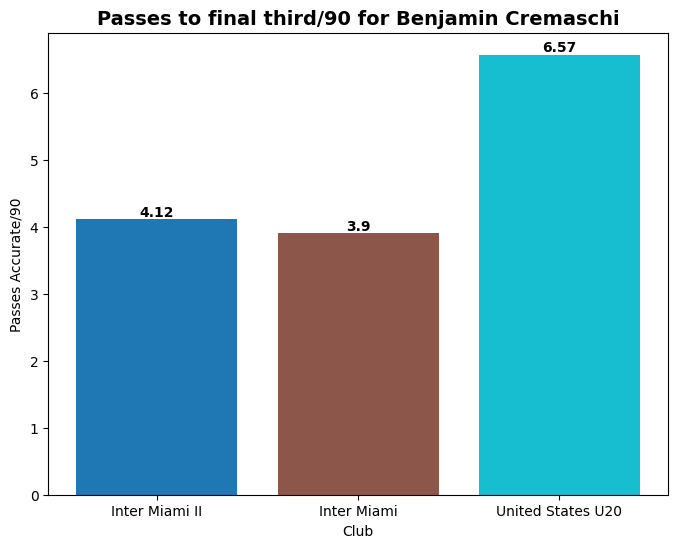

In [67]:
visualize_metric_between_teams(cremaschi_teams_df, "Passes to final third/90", "Benjamin Cremaschi") 

90s played for each player in the academy

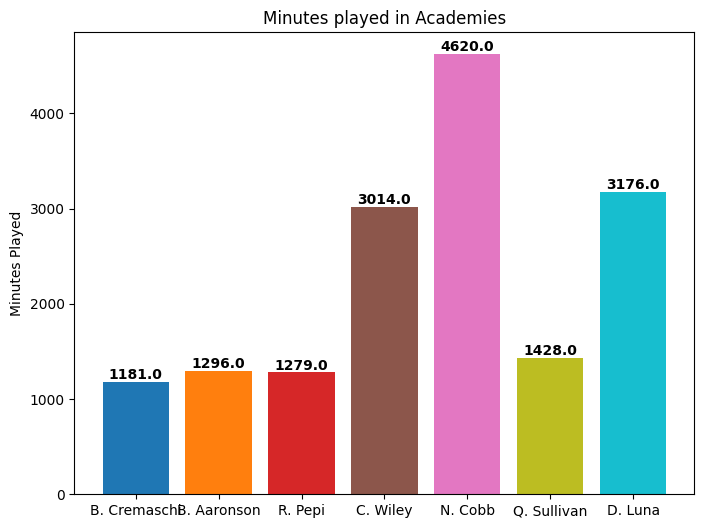

In [69]:
labels = ["B. Cremaschi", "B. Aaronson", "R. Pepi" ,"C. Wiley", "N. Cobb", "Q. Sullivan", "D. Luna"]
values = [cremaschi_teams_df.loc['Inter Miami II', 'Minutes played'],
            aaronson_teams_df.loc['Bethlehem Steel', 'Minutes played'],
            pepi_teams_df.loc['North Texas', 'Minutes played'],
            wiley_teams_df.loc['Atlanta United II', 'Minutes played'],
            cobb_teams_df.loc['Atlanta United II', 'Minutes played'],
            sullivan_teams_df.loc['Philadelphia Union II', 'Minutes played'],
            luna_teams_df.loc['El Paso Locomotive', 'Minutes played']
            ]

cmap = plt.colormaps['tab10']
colors = cmap(np.linspace(0, 1, len(labels)))

# Create the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, values, color=colors)
for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add titles and labels
plt.title('Minutes played in Academies')
plt.ylabel("Minutes Played")

# Show the plot
plt.show()
